In [3]:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu

In [68]:
# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number
wf_npixels = 1024

# same for psf
psf_npixels = 128

# no need for oversampling
oversample = 1

# toliman pixel scale
psf_pixel_scale = 0.375

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

In [69]:
# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

In [70]:
# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

In [71]:
# making the initial source

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))

# many photons
flux = 1e6 #1 million photons

# source
source = dl.PointSource(wavelengths, position, flux, weights)

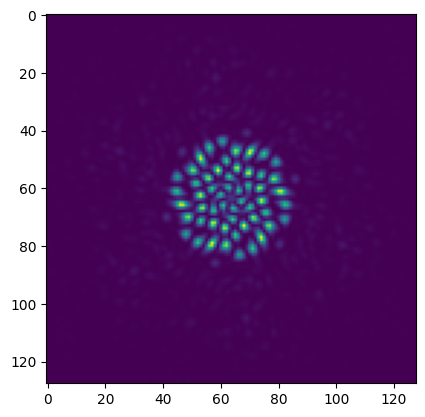

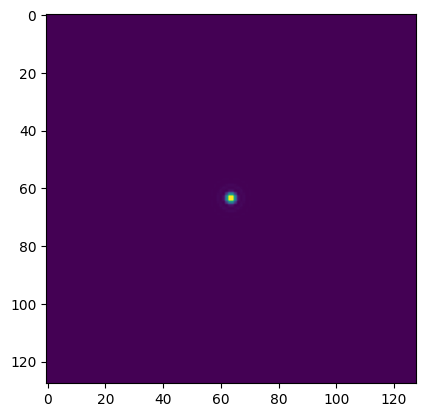

In [72]:
# getting the psfs!
airyPsf = airyApertureSystem.model(source)

tolPsf = tolPupilSystem.model(source)

plt.imshow(tolPsf)
plt.show()
plt.imshow(airyPsf)
plt.show()

In [73]:
# need to now make functions calculating the gradient
# do we need pixel scale?

# initialising derivative array
airyPsfDx = np.zeros_like(airyPsf)

# first column (forward difference)
airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

# middle columns (middle difference)
airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

# final column (backwards difference)
airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

# now for toliman
# initialising derivative array
tolPsfDx = np.zeros_like(tolPsf)

# first column (forward difference)
tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

# middle columns (middle difference)
tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

# final column (backwards difference)
tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

In [74]:
airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

In [75]:
# arcseconds!
print(psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare))
print(psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare))

0.0002621983
0.0004430221


In [78]:
# now... generate a lot of them for many photon counts and get some numbers
fluxes = np.logspace(3,9,7)

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))

airyCramer = np.zeros_like(fluxes)
tolCramer = np.zeros_like(fluxes)

# many photons
for i, flux in enumerate(fluxes):
    # source
    source = dl.PointSource(wavelengths, position, flux, weights)
    airyPsf = airyApertureSystem.model(source)

    tolPsf = tolPupilSystem.model(source)

    # need to now make functions calculating the gradient
    # do we need pixel scale?

    # initialising derivative array
    airyPsfDx = np.zeros_like(airyPsf)

    # first column (forward difference)
    airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

    # middle columns (middle difference)
    airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

    # final column (backwards difference)
    airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

    # now for toliman
    # initialising derivative array
    tolPsfDx = np.zeros_like(tolPsf)

    # first column (forward difference)
    tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

    # middle columns (middle difference)
    tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

    # final column (backwards difference)
    tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

    airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
    tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

    airyCramer[i] = psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare)
    tolCramer[i] = psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare)



In [79]:
print(airyCramer)
print(tolCramer)

[8.29143822e-03 2.62198318e-03 8.29143799e-04 2.62198300e-04
 8.29143828e-05 2.62198246e-05 8.29143846e-06]
[1.40095875e-02 4.43022000e-03 1.40095875e-03 4.43022087e-04
 1.40095857e-04 4.43022072e-05 1.40095835e-05]


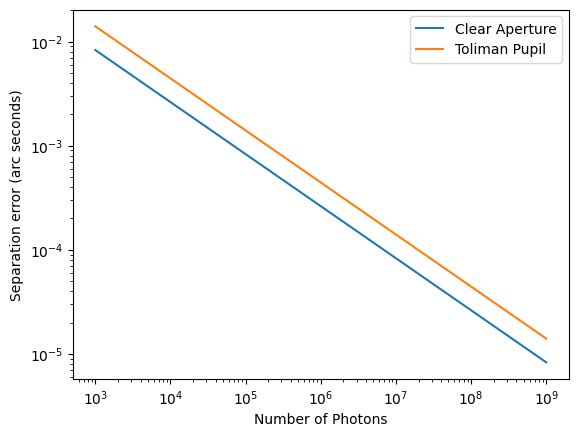

In [86]:
plt.loglog(fluxes,airyCramer,label='Clear Aperture')
plt.loglog(fluxes,tolCramer,label='Toliman Pupil')
plt.xlabel('Number of Photons')
plt.ylabel('Separation error (arc seconds)')
plt.legend()
plt.show()